In [192]:
# torch 및 torchaudio 라이브러리 설치
!pip install torch
!pip install torchaudio
!pip install librosa

^C
Looking in indexes: http://ftp.daumkakao.com/pypi/simple
Looking in indexes: http://ftp.daumkakao.com/pypi/simple
Looking in indexes: http://ftp.daumkakao.com/pypi/simple


In [193]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchaudio

In [194]:
# 용량 초과 관계로 직접 다운로드 받아 사용하는 방식으로 할 것 (331MB)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

In [195]:
test_dataset[0]

(tensor([[0.0003, 0.0003, 0.0004,  ..., 0.0021, 0.0021, 0.0016]]),
 16000,
 'HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE',
 1089,
 134686,
 0)

In [196]:
# 음성 데이터 예제를 바탕으로 실습 진행
audioData = test_dataset[0][0][0] # [0]만 했을 때 shape 가 (1, ?) 으로 뜸.
sr = test_dataset[0][1] # Sampling Rate
# nyquist-shannon sampling theorem 을 바탕으로 A/D를 거치고, D/A로 복원하기 위해서는
# 표본화 된 신호의 최대 주파수가 두 배 보다 더 클 때 가능하다고 함.
# 정리하여, 최대 Frequency 의 절반으로 설정.
# 통상적으로, 16KHz(Speech), 22.05KHz, 44.1KHz (Music)
audioData, audioData.shape

(tensor([0.0003, 0.0003, 0.0004,  ..., 0.0021, 0.0021, 0.0016]),
 torch.Size([166960]))

In [197]:
len(audioData) / sr # duration (시간 단위)

10.435

In [198]:
import IPython.display as ipd
ipd.Audio(audioData, rate=sr) # Sound Player

In [199]:
# Resampling using interpolation low-pass filter
y_8k = librosa.resample(audioData.numpy(), sr, 8000)
ipd.Audio(y_8k, rate=8000)

C:\Users\devtae\AppData\Local\Temp/ipykernel_18444/1727624607.py:2: FutureWarning: Pass orig_sr=16000, target_sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_8k = librosa.resample(audioData.numpy(), sr, 8000)


In [200]:
len(y_8k) / 8000

10.435

In [201]:
# Resampling using interpolation low-pass filter
y_4k = librosa.resample(audioData.numpy(), sr, 4000)
ipd.Audio(y_4k, rate=4000)

C:\Users\devtae\AppData\Local\Temp/ipykernel_18444/472377201.py:2: FutureWarning: Pass orig_sr=16000, target_sr=4000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_4k = librosa.resample(audioData.numpy(), sr, 4000)


In [202]:
len(y_4k) / 4000

10.435

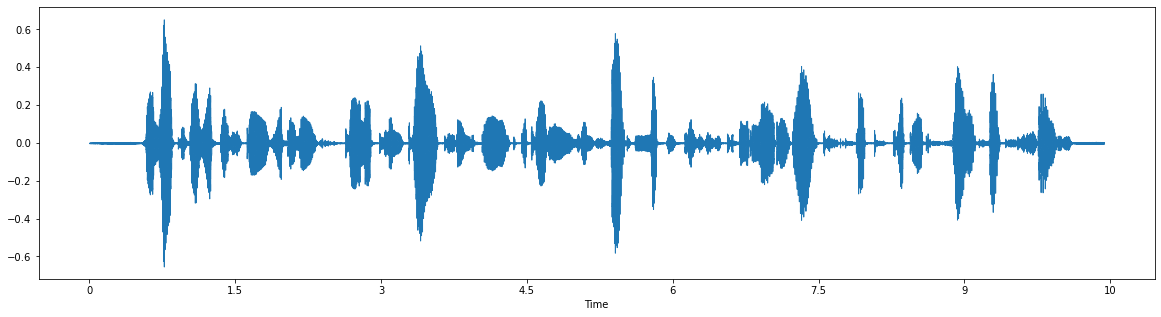

In [203]:
import librosa.display

audio_np = audioData.numpy() # tensorflow array -> numpy 변환

fig = plt.figure(figsize = (20, 5))
librosa.display.waveshow(audio_np, sr=sr)

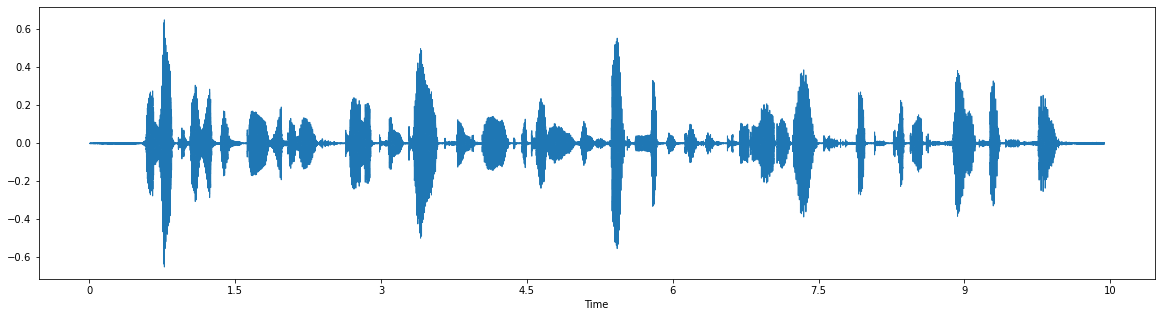

In [216]:
fig = plt.figure(figsize = (20, 5))
librosa.display.waveshow(y_8k, sr=8000) # sr = 8000 으로 리샘플링한 음성 데이터의 waveshow 출력 / 잔파동에 대한 수치가 줄어듦

In [205]:
# Normalization

audio_np = audioData.numpy()
normed_wav = audio_np / max(np.abs(audio_np)) # 전부를 최댓값으로 나눔
ipd.Audio(normed_wav, rate=sr)

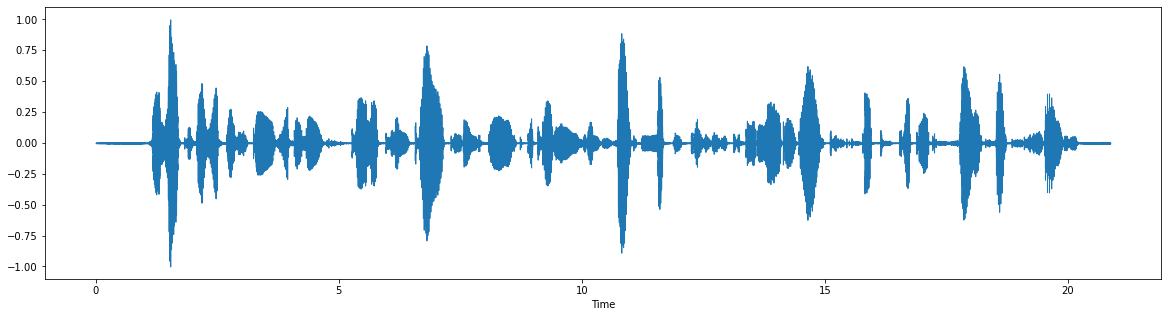

In [206]:
fig = plt.figure(figsize = (20, 5))
librosa.display.waveshow(normed_wav, sr=8000) # -1 ~ 1 사이에 데이터가 포함되어 있는 것을 확인할 수 있음

In [229]:
# Quantization
# 큰 데이터 다루거나 네트워크가 라이트 모델의 경우 Quantization 이 필요함
# 데이터가 경량화되지만 그만큼 노이즈가 생기기도 함 (기계음 발생)

# B bit의 Quantization : -2^(B-1) ~ 2^(B-1) - 1
# Audio CD의 Quantization (16bits) : -2^(15) ~ 2^15 - 1
# 위 값들은 보통 -1.0 ~ 1.0 영역으로 scaling 되기도 한다.

Bit = 4
max_value = 2 ** (Bit - 1)

quantized_8_wav = normed_wav * max_value
quantized_8_wav = np.round(quantized_8_wav)#.astype(int) # waveshow 함수를 호출하기 위해서는 데이터가 floating value 여야 함
quantized_8_wav = np.clip(quantized_8_wav, -max_value, max_value - 1) # clip 함수는 범위 바깥 수치를 수정해주는 것임
ipd.Audio(quantized_8_wav, rate=sr)

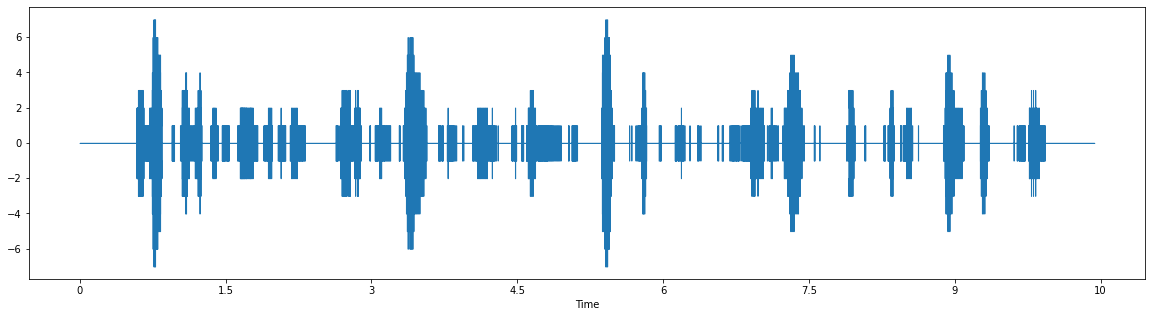

In [230]:
fig = plt.figure(figsize = (20, 5))
librosa.display.waveshow(quantized_8_wav, sr=sr) # 값이 엄청나게 경량화된 것을 확인할 수 있음

In [209]:
# Amplitude(Intensity) : 진폭
# Frequency : 주파수
# Phase (Degress of fdisplacement) : 위상

# 복합파(Complex wave)는 복수의 서로 다른 정현파들의 합으로 이루어진 파형임

# 정현파(Sinusoid) : 일종의, 복소수가 있는 주기함수 x(n) ~= sum(k=0~K)(amplitude(n) * cos(phase(n)) + e(n)
# amplitude(n) : instantaneous amplitude (소리의 크기)
# phase(n) : instantaneous phase (복소수 영역 / 위상(Phase), 그리고 Frequency 값도 들어가야 함)
# e(n) : residual (noise)
# -----
# sum : t/fs
# amplitude(n) : Int 처리
# cos : np.cos
# phase(n) : np.pi (+ Frequency 처리)

In [210]:
# 정현파 생성
A = 0.9 # Amplitude
f = 440 # Frequency (음 : 라) / 진동수 올라갈수록 음 높아짐
phi = np.pi/2 # pie/2
fs = 22050 # sampling rate
t = 1 # 1초

In [211]:
def Sinusoid(A, f, phi, fs, t):
    t = np.arange(0, t, 1.0/fs) # 0 부터 t 까지 1.0/fs 만큼의 증가를 바탕으로 나열된 수열이 만들어짐
    x = A * np.cos(2 * np.pi * f * t + phi) # np.cos 함수 안에 들어가 있는 인자가 phase(n) 과 동일함
    return x

In [212]:
sin = Sinusoid(A, f, phi, fs, t)
print(sin)
ipd.Audio(sin, rate=fs)

[ 5.51091060e-17 -1.12545471e-01 -2.23324063e-01 ...  3.30596635e-01
  2.23324063e-01  1.12545471e-01]


In [239]:
# 복합파 생성
sin1 = Sinusoid(0.9, 200, phi, fs, t)
sin2 = Sinusoid(0.9, 400, phi, fs, t)
sin3 = Sinusoid(0.9, 800, phi, fs, t)
complexwave = sin1 + sin2 + sin3

ipd.Audio(complexwave, rate=fs) # 440, 460, 480 조합으로 했을 때, 마치 통화 연결음 같은 소리가 들림

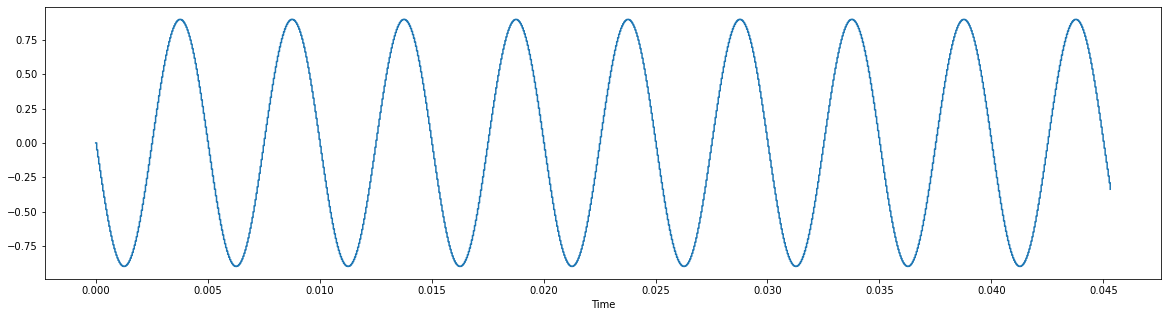

In [242]:
# 각각의 정현파 출력
# 전체 파동을 그리면 전체를 꽉 채우는 그림이 나오기에 일부만 출력하도록 하였음
fig = plt.figure(figsize = (20, 5))
librosa.display.waveshow(sin1[0:1000], sr=22050)

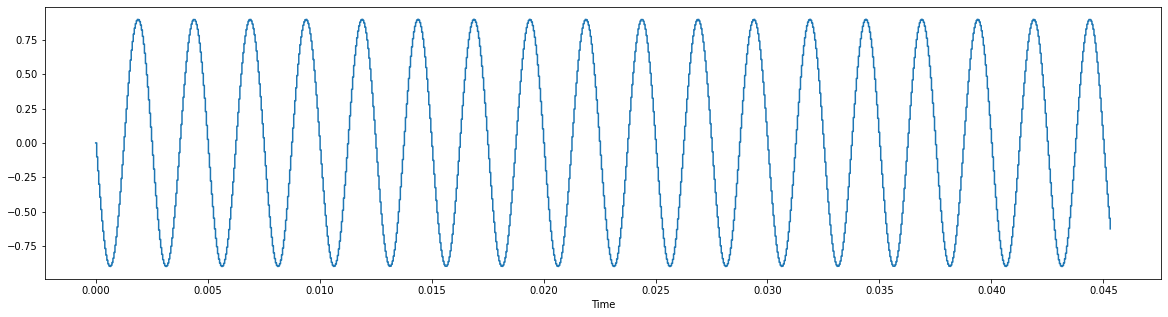

In [243]:
fig = plt.figure(figsize = (20, 5))
librosa.display.waveshow(sin2[0:1000], sr=22050)

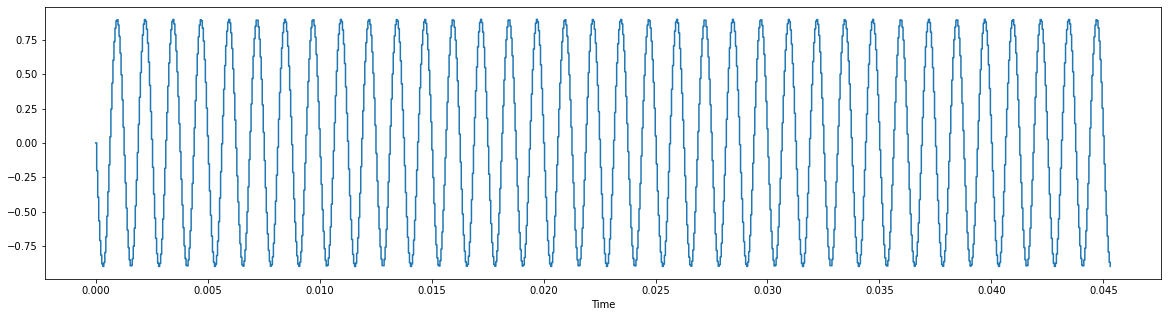

In [244]:
fig = plt.figure(figsize = (20, 5))
librosa.display.waveshow(sin3[0:1000], sr=22050)

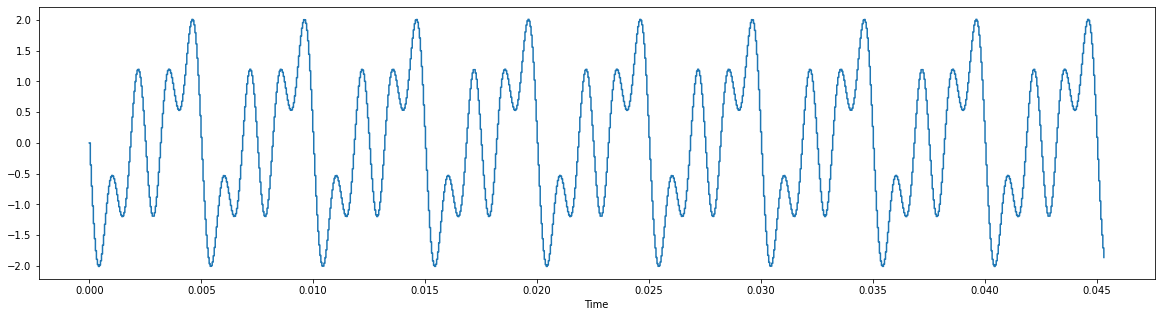

In [245]:
fig = plt.figure(figsize = (20, 5))
librosa.display.waveshow(complexwave[0:1000], sr=22050) # 정현파가 합쳐지면서 복합파가 된 것을 확인할 수 있음

C:\Users\devtae\AppData\Local\Temp/ipykernel_18444/824386184.py:2: FutureWarning: Pass y=[ 1.65327318e-16 -3.57017088e-01 -7.02015431e-01 ...  1.02353859e+00
  7.02015431e-01  3.57017088e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(complexwave, sr=fs, n_mels=128)


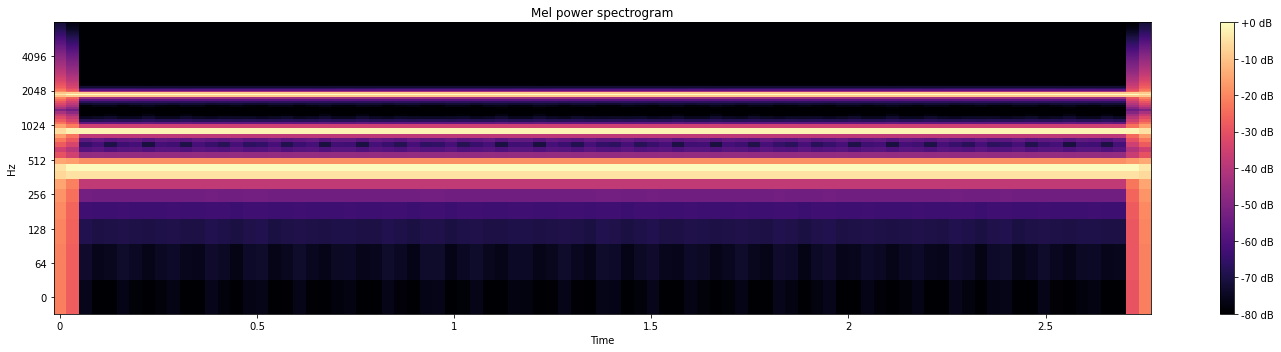

In [214]:
# Spectrogram 을 통하여 해당 음역대 활성화 확인 가능
S = librosa.feature.melspectrogram(complexwave, sr=fs, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
fig = plt.figure(figsize = (20, 5))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='log')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()